# Deep learning for hyperspectral image processing: Multi-layer perceptron networks
This notebook demonstrates application of Multi-Layer Perceptron (MLP) networks to land use classification. Two seperate notebooks are also available describing the applications of 2-Dimensional Convolutional Neural Network [(2-D CNN)](deep_learning_2D_CNN.ipynb) and 3-Dimenaional Convolutional Neural Network [(3-D CNN)](deep_learning_3D_CNN.ipynb) models to landuse classification. 


## Module imports
Below is the list of libraries and modules that are required in this notebook. The 'keras' package provides the building blocks for model configuration and training. The 'img_util' contains a set of useful functions for pre-processing of raw data to create input and output data containers, compatible to the 'keras' package. In addition, it provides a set of functions for post-processing of results and visualization of prediction maps.
The 'sio' and 'os' module were used for working with external files. The plotting of data and generation of prediction maps were achieved using plotting functionalities of 'matplotlib'.

In [1]:
import numpy as np
from keras import models, layers, optimizers, metrics, losses, regularizers
import img_util as util
from scipy import io as sio
import os
from matplotlib import pyplot as plt

2025-02-07 11:01:52.445901: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-07 11:01:52.469869: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-07 11:01:52.796899: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Hyperspectral dataset
A set of publically-available hyperspectral imageray datasets can be downloaded form [this](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes) website. The Indian Pine dataset was downloaded and used in this notebook. The dataset consists of 150*150 pixels with 200 refelactance bands. The ground truth data for the dataset consists of 16 different classes. A summary of landuse types and their corresponding number of samples can be found in the following table:

| ID       | Class                        | Samples |
|----------|------------------------------|---------|
| 0        | Unlabeled                    | 10776   |
| 1        | Alfalfa                      | 46      |
| 2        | Corn-notill                  | 1428    |
| 3        | Corn-mintill                 | 830     |
| 4        | Corn                         | 237     |
| 5        | Grass-pasture                | 483     |
| 6        | Grass-trees                  | 730     |
| 7        | Grass-pasture-mowed          | 28      |
| 8        | Hay-windrowed                | 478     |
| 9        | Oats                         | 20      |
| 10       | Soybean-notill               | 972     |
| 11       | Soybean-mintill              | 2455    |
| 12       | Soybean-clean                | 593     |
| 13       | Wheat                        | 205     |
| 14       | Woods                        | 1265    |
| 15       | Buildings-Grass-Trees-Drives | 386     |
| 16       | Stone-Steel-Towers           | 93      |

The image data and class labels are available in two separate Matlab files with .mat extension. Therefore, the data were loaded into Python using the 'loadmat' function, available in the 'io' module of Scipy. 

In [2]:
data_folder = 'Datasets'
data_file= 'Indian_pines_corrected'
gt_file = 'Indian_pines_gt'
data_set = sio.loadmat(os.path.join(data_folder, data_file)).get('indian_pines_corrected')
gt = sio.loadmat(os.path.join(data_folder, gt_file)).get('indian_pines_gt')

# Checking the shape of data_set (containing image data) and gt (containing ground truth data) Numpy arrays.
print(data_set.shape ,gt.shape)

(145, 145, 200) (145, 145)


## Training and test data
The 'data_split' function was used for splitting the data into training and test sets using 0.85 as the split ratio (85% of labeled pixels were used for training). This function ensures that all classes are represented in the training dataset (see function documentation for available split methods). In addition, it allows users to focus their analysis on certain classes and remove those pixels that are not labeled. For example, the unlabeled data are represented by 0 in the gourd truth data file. Therefore, 0 was included in 'rem_classes' list, indicating its removal from the dataset.

In [3]:
train_fraction = 0.85
rem_classes = [0]
(train_rows, train_cols), (test_rows, test_cols) = util.data_split(gt,
                                                                   train_fraction=train_fraction,
                                                                   rem_classes=rem_classes)

print('Number of training samples = {}.\nNumber of test samples = {}.'.format(len(train_rows), len(test_rows)))

Number of training samples = 8705.
Number of test samples = 1543.


A portion of training data can optionally be set aside for validation.

In [4]:
val_fraction = 0.05
(train_rows_sub, train_cols_sub), (val_rows, val_cols) = util.val_split(
        train_rows, train_cols, gt, val_fraction=val_fraction)

## Dimensionality reduction
The spectral dimension of an image dataset can be reduced using Principle Component Analysis (PCA). Although, this step is not necessary, it could significantly reduce the spectral dimension without losing important information. The 'reduce_dim' function takes the numpy array containing image data as its first argument and the number of reduced dimensions (i.e., an integer) or the minimum variance captured by PCA dimensions (i.e., a float) as the second argument.   

In [5]:
data_set = util.reduce_dim(img_data=data_set, n_components=.999)
data_set.shape


(145, 145, 69)

Using a value of 0.999 for the percentage of captured variance, The spectral dimension was reduced from 200 to 69 bands. The new dimensions were sorted according to their contribution to the dataset variance. The top 10 dimensions of transformed data are illustrated below.

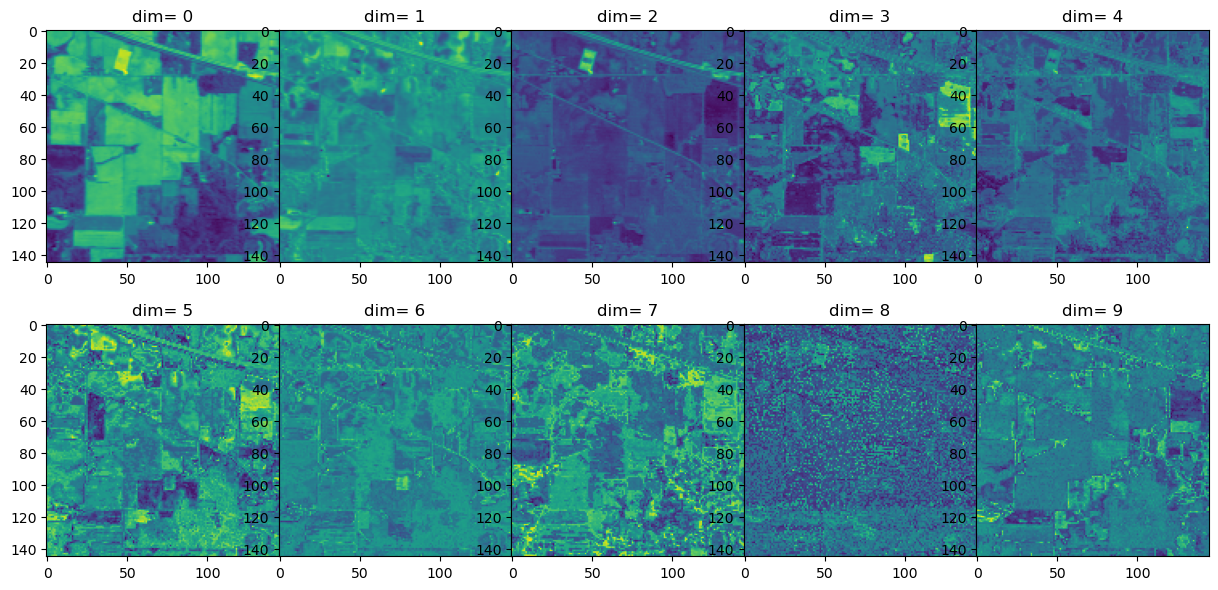

In [6]:
fig, axes = plt.subplots(2,5, figsize=(15,7))
for numb, axe in enumerate(axes.flat):
    axe.imshow(data_set[:,:,numb])
    axe.set_title('dim='+' '+str(numb))
    
fig.subplots_adjust(wspace=0, hspace=.2)
plt.show()

## Rescaling data
The 'rescale_data' function provides four methods for rescaling data at each spectral dimension. In this notebook, the'standard' method which transforms the data to have zero mean a standard deviation of 1 was used for rescaling data.

In [7]:
data_set = util.rescale_data(data_set)

## Creating input and target tensors
The input and target tensors should be compatible with the type of neural network model that is used for classification. The 'create_patch' function can create inputs, compatible to both pixel inputs for [MLP](deep_learning_MLP.ipynb) models as well as patch inputs for [2-D CNN](deep_learning_2D_CNN.ipynb) and [3-D CNN](deep_learning_3D_CNN.ipynb) models. 
In this notebook, an MLP model was used for classification. Each pixel in the training dataset would constitute an input to the neural network model, therefore the value of 'patch_size' parameter should be set to 1.

In [8]:
patch_size=1
train_pixel_indices_sub = (train_rows_sub, train_cols_sub)
val_pixel_indices = (val_rows, val_cols)
test_pixel_indices = (test_rows, test_cols) 
catg_labels = np.unique([int(gt[idx[0],idx[1]]) for idx in zip(train_rows, train_cols)])
int_to_vector_dict = util.label_2_one_hot(catg_labels) 

train_input_sub, y_train_sub = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=train_pixel_indices_sub,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

val_input, y_val = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=val_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

test_input, y_test = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=test_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

## Creating an MLP neural network model
The network architecture consists of an input layer whose neurons correspond to the dimension of inputs (i.e., the number of spectral bands). The input layer is followed by a Flatten layer which merely reshape the outputs of the input layer. The third layer is a 'dense' layer and contains the hidden neurons. A Dropout layer is placed after the hidden layer which randomly sets to zero the outputs of the hidden layer during the training phase. The last layer is the output layer whose dimension depends on the number of classes.  

In [9]:
units_1 = 2**8
drop_rate =0.35
num_catg = len(catg_labels)
input_shape = (patch_size, patch_size, data_set.shape[-1])

# Building a MLP network model
nn_model = models.Sequential()
#
# dense_input
nn_model.add(layer=layers.Dense(units=data_set.shape[2], activation='relu',
                                input_shape=input_shape))
# flatten_1, changes input shape from (1,1,num_band) to (num_band,)
nn_model.add(layer=layers.Flatten())
# dense_1
nn_model.add(layer=layers.Dense(units=units_1, activation='relu')) 
# dropout_1
nn_model.add(layer=layers.Dropout(drop_rate))
# dense_output
nn_model.add(layer=layers.Dense(units=num_catg, activation='softmax'))

nn_model.summary()


/home/iyeszin/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-07 11:01:59.059532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-07 11:01:59.078779: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1, 1, 69)       │         4,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 69)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,862 (104.93 KB)

 Trainable params: 26,862 (104.93 KB)

 Non-trainable params: 0 (0.00 B)

## Training model and plotting training history
The model was compiled and trained using the training, validation and test [data.](#Creating-input-and-target-tensors) 

I0000 00:00:1738922519.564254 1184666 service.cc:145] XLA service 0x77cce8004a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738922519.564269 1184666 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-02-07 11:01:59.575430: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-07 11:01:59.615931: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1738922520.625480 1184666 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


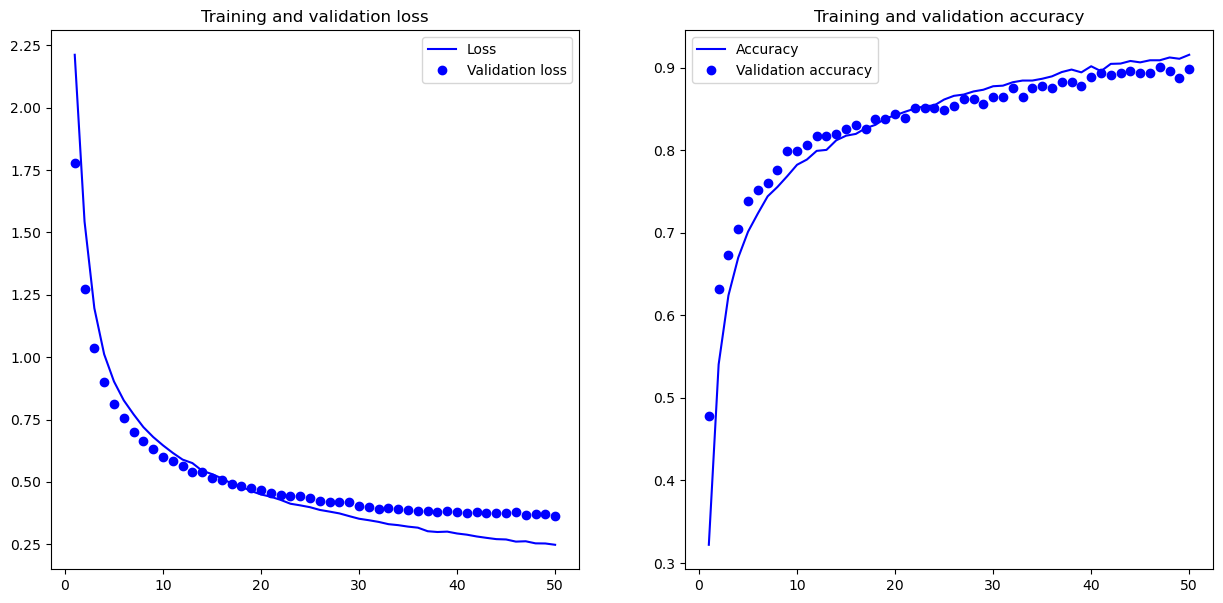

In [10]:
lr = 1e-4
batch_size = 2**3

# Compiling the modele
nn_model.compile(optimizer=optimizers.RMSprop(learning_rate=lr),
                 loss=losses.categorical_crossentropy,
                 metrics=[metrics.categorical_accuracy])

# Training the model
history = nn_model.fit(x=train_input_sub, y=y_train_sub, batch_size=batch_size,
                       epochs=50, validation_data=(val_input, y_val), verbose=False)

# Plotting history
epoches = np.arange(1,len(history.history.get('loss'))+1)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(15, 7))
ax1.plot(epoches, history.history.get('loss'), 'b',label='Loss')
ax1.plot(epoches, history.history.get('val_loss'),'bo', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.legend()
ax2.plot(epoches, history.history.get('categorical_accuracy'), 'b',label='Accuracy')
ax2.plot(epoches, history.history.get('val_categorical_accuracy'),'bo', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.legend()
plt.show()

## Model performance evaluation
Overall loss and accuracy of the model was calculated using the 'evaluate' method. The loss and accuracy for each class was also calculated using the 'calc_metrics' function of the 'img_util' module.  

In [11]:
overall_loss, overal_accu = nn_model.evaluate(test_input, y_test, verbose=False)
print('Overall loss = {}'.format(overall_loss))
print('Overall accuracy = {}\n'.format(overal_accu))

# Calculating accuracy for each class
model_metrics = util.calc_metrics(nn_model, test_input,
                                           y_test, int_to_vector_dict, verbose=False)

#Printing accuracy per class
print('{}{:>13}\n{}'.format('Class ID','Accuracy', 30*'_'))
for key, val in model_metrics.items():
    print(('{:>2d}{:>18.4f}\n'+'{}').format(key, val[0][1], 30*'_'))

Overall loss = 0.4658472537994385
Overall accuracy = 0.8580687046051025



I0000 00:00:1738922546.753052 1188888 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_56', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1738922549.368330 1189575 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_56', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1738922549.884088 1189681 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_56', 8 bytes spill stores, 8 bytes spill loads



Class ID     Accuracy
______________________________
 1            0.8571
______________________________
 2            0.8000
______________________________
 3            0.7440
______________________________
 4            0.6667
______________________________
 5            0.9178
______________________________
 6            0.9545
______________________________
 7            0.2000
______________________________
 8            1.0000
______________________________
 9            0.0000
______________________________
10            0.8493
______________________________
11            0.8699
______________________________
12            0.7753
______________________________
13            1.0000
______________________________
14            0.9789
______________________________
15            0.7414
______________________________
16            0.7143
______________________________


## Making predictions using using test data
The trained model was used for label predictions using the training, validation, and test datasets. It was also used to make label prediction for the entire dataset including unlabeled pixels.

10248/10248 ━━━━━━━━━━━━━━━━━━━━ 3s 293us/step


/tmp/ipykernel_1184507/2868176434.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(int_to_vector_dict))


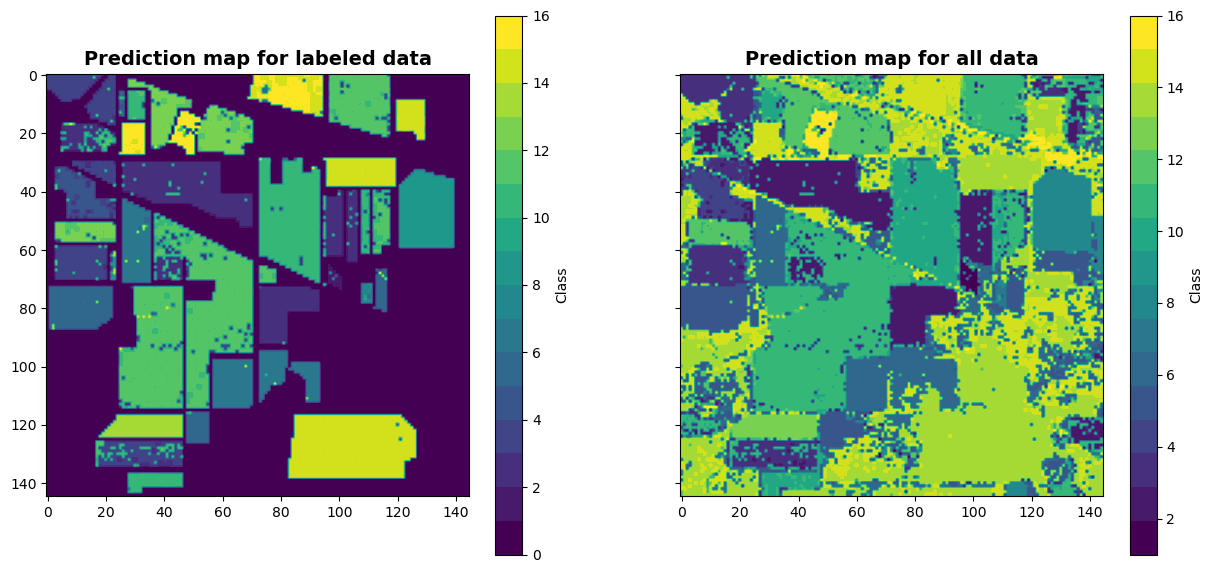

In [12]:
# Plotting predicted results
concat_rows =  np.concatenate((train_rows_sub, val_rows, test_rows))
concat_cols = np.concatenate((train_cols_sub, val_cols, test_cols))
concat_input = np.concatenate((train_input_sub, val_input, test_input))
concat_y = np.concatenate((y_train_sub, y_val, y_test))
pixel_indices = (concat_rows, concat_cols)


# First, let's modify the plotting code to handle the prediction mapping more carefully:
def safe_plot_full_map(nn_model, data_set, gt, int_to_vector_dict, patch_size, plo=False):
    rows, cols = gt.shape
    all_predictions = np.zeros((rows, cols))
    
    # Create patches for each pixel
    for i in range(rows):
        for j in range(cols):
            # Extract patch
            r_start = max(0, i - patch_size//2)
            r_end = min(rows, i + patch_size//2 + 1)
            c_start = max(0, j - patch_size//2)
            c_end = min(cols, j + patch_size//2 + 1)
            
            patch = data_set[r_start:r_end, c_start:c_end, :]
            
            # Pad if necessary
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                pad_r = patch_size - patch.shape[0]
                pad_c = patch_size - patch.shape[1]
                patch = np.pad(patch, ((0, pad_r), (0, pad_c), (0, 0)), mode='constant')
            
            # Reshape for model input
            patch = patch.reshape(1, 1, 1, -1)  # Adjust shape based on your model's input requirements
            
            # Get prediction
            pred = nn_model.predict(patch, verbose=0)
            pred_class = np.argmax(pred) + 1  # Assuming classes start from 1
            
            all_predictions[i, j] = pred_class
            
    return all_predictions

# Now let's try plotting with the modified function
try:
    # Plot partial map
    partial_map = util.plot_partial_map(
        nn_model, 
        gt, 
        pixel_indices, 
        concat_input,
        concat_y, 
        int_to_vector_dict, 
        plo=False
    )
    
    # Plot full map using our safe function
    full_map = safe_plot_full_map(
        nn_model, 
        data_set, 
        gt, 
        int_to_vector_dict, 
        patch_size, 
        plo=False
    )
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(
        nrows=1, 
        ncols=2, 
        sharex=True, 
        sharey=True,
        figsize=(15, 7)
    )
    
    # Plot with a consistent colormap
    cmap = plt.cm.get_cmap('viridis', len(int_to_vector_dict))
    
    im1 = ax1.imshow(partial_map, cmap=cmap)
    ax1.set_title('Prediction map for labeled data', fontweight="bold", fontsize=14)
    
    im2 = ax2.imshow(full_map, cmap=cmap)
    ax2.set_title('Prediction map for all data', fontweight="bold", fontsize=14)
    
    # Add colorbar
    plt.colorbar(im1, ax=ax1, label='Class')
    plt.colorbar(im2, ax=ax2, label='Class')
    
    plt.show()

except Exception as e:
    print(f"Error: {str(e)}")
    print(f"\nDetailed error information:")
    import traceback
    traceback.print_exc()

The prediction map may be further improved using an appropriate filter (e.g. median filter) for removing the salt-and-pepper noise from the predicted pixels. Alternatively, CNN models which are less prone to producing a noisy prediction map could be used for landuse classification.

See also:
### [Deep learning for hyperspectral image processing: Multi-layer perceptron networks](deep_learning_MLP.ipynb)
### [Deep learning for hyperspectral image processing: 2-D convolutional neural networks](deep_learning_2D_CNN.ipynb)
### [Deep learning for hyperspectral image processing: 3-D convolutional neural networks](deep_learning_3D_CNN.ipynb)